In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

from cleaning import df
sns.set()

I will be doing a supervised learning method to try to predict whether a player will be an all star. I want to test a few different types of models. 
- Logistic Regression
- Random Forest
- Support Vector Machine
- K-Nearest Neighbors


In order to check the predictive power of my model, I will look at the confusion matrix, ROC Curve, and classicifcaiton report.

The first model I am going to trye is Logistic Regression. To begin, I need to split my data into test set and training set.

In [14]:
from sklearn.model_selection import train_test_split

int_df = df.select_dtypes(exclude=object)

Xtrain, Xtest, ytrain, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

cv = []
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for C in Cs:    
    lr = LogisticRegression(C=C, solver='lbfgs')
    scores = cross_val_score(lr, Xtrain, ytrain, cv= 5)
    cv.append('Accuracy for C={}: {} (+/- {})'.format(C, scores.mean(), scores.std()*2))

cv

C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs 

['Accuracy for C=0.001: 0.7737350397178913 (+/- 0.0294655903944871)',
 'Accuracy for C=0.01: 0.7858278419461406 (+/- 0.021813696557483064)',
 'Accuracy for C=0.1: 0.7965431390477555 (+/- 0.010072693582894901)',
 'Accuracy for C=1: 0.7993065200730578 (+/- 0.012980003505726883)',
 'Accuracy for C=10: 0.802068718227078 (+/- 0.011326486248625176)',
 'Accuracy for C=100: 0.7982696550858622 (+/- 0.014897287078475542)',
 'Accuracy for C=1000: 0.8010318532398826 (+/- 0.011737410199853044)']

The best value for C is 0.1. 


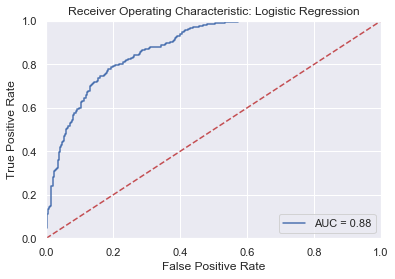

In [4]:
from sklearn.metrics import roc_curve, auc

int_df = df.select_dtypes(exclude=object)

X, Xtest, y, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)
lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1500)
lr.fit(X, y)
probs = lr.predict_proba(Xtest)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

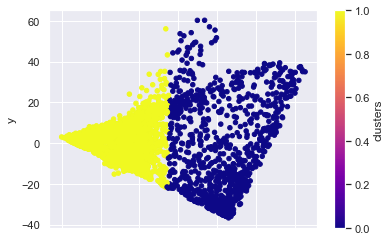

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca = PCA(n_components=2)
principal = pca.fit_transform(int_df)
pca_df = pd.DataFrame({'x':principal[:,0],
                      'y':principal[:,1]})

kmn = KMeans(n_clusters=2)
kmn.fit(pca_df)
cluster_df = pd.DataFrame({'cluster':kmn.labels_})

pca_df['clusters'] = cluster_df

pca_df.plot(kind='scatter', x='x', y='y', c='clusters', cmap='plasma')

In [6]:
from sklearn.neighbors import KNeighborsClassifier
int_df = df.select_dtypes(exclude=object)

X, Xtest, y, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X,y)
    ypred = knn.predict(Xtest)
    print('{} Neighbors Accuracy: {}'.format(i, accuracy_score(ytest, ypred)))

1 Neighbors Accuracy: 0.7295336787564767
2 Neighbors Accuracy: 0.7295336787564767
3 Neighbors Accuracy: 0.7430051813471502
4 Neighbors Accuracy: 0.7502590673575129
5 Neighbors Accuracy: 0.7637305699481866
6 Neighbors Accuracy: 0.772020725388601
7 Neighbors Accuracy: 0.7709844559585493
8 Neighbors Accuracy: 0.7792746113989637
9 Neighbors Accuracy: 0.7751295336787565


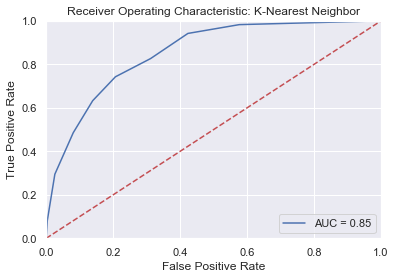

In [7]:
from sklearn.metrics import roc_curve, auc

int_df = df.select_dtypes(exclude=object)

X, Xtest, y, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X, y)
probs = knn.predict_proba(Xtest)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic: K-Nearest Neighbor')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

    
X, Xtest, y, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)

accuracy = dict()
for i in range(1, len(int_df.columns)):
    rfc = RandomForestClassifier(n_estimators=i)
    rfc.fit(X,y)
    ypred = rfc.predict(Xtest)
    print('Accuracy for {} Estimators:\n'.format(i),classification_report(ytest, ypred,))

Accuracy for 1 Estimators:
               precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       619
         1.0       0.64      0.70      0.66       346

    accuracy                           0.75       965
   macro avg       0.73      0.74      0.73       965
weighted avg       0.75      0.75      0.75       965

Accuracy for 2 Estimators:
               precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       619
         1.0       0.72      0.53      0.61       346

    accuracy                           0.76       965
   macro avg       0.75      0.71      0.72       965
weighted avg       0.75      0.76      0.75       965

Accuracy for 3 Estimators:
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.80       619
         1.0       0.63      0.64      0.64       346

    accuracy                           0.74       965
   macro avg       0.72      0.72      0.72 

Accuracy for 25 Estimators:
               precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       619
         1.0       0.70      0.70      0.70       346

    accuracy                           0.78       965
   macro avg       0.76      0.76      0.76       965
weighted avg       0.78      0.78      0.78       965

Accuracy for 26 Estimators:
               precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       619
         1.0       0.70      0.68      0.69       346

    accuracy                           0.78       965
   macro avg       0.76      0.76      0.76       965
weighted avg       0.78      0.78      0.78       965

Accuracy for 27 Estimators:
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       619
         1.0       0.70      0.72      0.71       346

    accuracy                           0.79       965
   macro avg       0.77      0.77      0.

In [9]:
classify = classification_report(ytest, ypred, output_dict=True)
classify['0.0']

{'f1-score': 0.835360908353609,
 'precision': 0.8387622149837134,
 'recall': 0.8319870759289176,
 'support': 619}

In [10]:
from sklearn.metrics import roc_curve, auc

int_df = df.select_dtypes(exclude=object)

X, Xtest, y, ytest = train_test_split(int_df.loc[:, int_df.columns != 'allstar_next'].values,
                                     int_df.loc[:, 'allstar_next'].values, random_state=10)
rfc = RandomForestClassifier(C=0.1, solver='lbfgs', max_iter=1500)
lr.fit(X, y)
probs = lr.predict_proba(Xtest)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(ytest, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'C'